In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.xkcd()
plt.rcParams['font.family'] = "xkcd"

In [5]:
gpu_headers = []
for gpu in range(8):
    gpu_headers.append(f"Allocated MiB cuda{gpu}")
    gpu_headers.append(f"Reserved MiB cuda{gpu}")

without_df = pd.read_csv(
    'initial-results-no-env-var.csv', 
    header=None,
    names=['Sequence length'] + gpu_headers + ['Iterations/second']
)
without_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,0,0,0,0,0,0,34593,44008,0,0,0,0,0,0,0,0,1.547439
1,1,34705,43896,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.547532
2,1,0,0,0,0,33377,43896,0,0,0,0,0,0,0,0,0,0,1.547443
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,33265,43896,1.547509
4,1,0,0,0,0,0,0,0,0,0,0,34369,43896,0,0,0,0,1.547480
5,1,0,0,0,0,0,0,0,0,0,0,0,0,33153,43896,0,0,1.547678
6,1,0,0,0,0,0,0,0,0,33153,43896,0,0,0,0,0,0,1.547379
7,1,0,0,34481,44008,0,0,0,0,0,0,0,0,0,0,0,0,1.547445
8,11,0,0,0,0,34848,46970,0,0,0,0,0,0,0,0,0,0,1.252515
9,11,34848,46970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.252508


In [7]:
def validate_gpu_allocation(df):
    issues = []
    sequence_lengths = df['Sequence length'].unique()
    
    for seq_length in sequence_lengths:
        group = df[df['Sequence length'] == seq_length]
        
        if len(group) != 8:
            issues.append(f"Sequence length {seq_length}: Expected 8 rows, but found {len(group)}")
            continue
        
        active_gpu_set = set()
        for i, row in group.iterrows():
            active_gpus = [(j, row[f'Allocated MiB cuda{j}']) for j in range(8) if row[f'Allocated MiB cuda{j}'] != 0]
            
            if len(active_gpus) != 1:
                issues.append(f"Sequence length {seq_length}, Row {i}: Has {len(active_gpus)} active GPUs, expected 1")
            else:
                gpu_num = active_gpus[0][0]
                if gpu_num in active_gpu_set:
                    issues.append(f"Sequence length {seq_length}: GPU {gpu_num} is active in multiple rows")
                active_gpu_set.add(gpu_num)
        
        if len(active_gpu_set) != 8:
            missing_gpus = set(range(8)) - active_gpu_set
            issues.append(f"Sequence length {seq_length}: Missing data for GPUs {missing_gpus}")
    
    if not issues:
        print("All rows validated OK")
    else:
        print("Validation issues found:")
        for issue in issues:
            print(f"- {issue}")
    
    print(f"Total sequence lengths checked: {len(sequence_lengths)}")

# Use the function
validate_gpu_allocation(without_df)

All rows validated OK
Total sequence lengths checked: 25


In [11]:
def normalize_gpu_data(df):
    # Group by sequence length
    grouped = df.groupby('Sequence length')
    
    normalized_data = []
    
    for seq_length, group in grouped:
        new_row = {'Sequence length': seq_length}
        
        # Combine GPU data
        for gpu in range(8):
            allocated = group[f'Allocated MiB cuda{gpu}'].max()
            reserved = group[f'Reserved MiB cuda{gpu}'].max()
            new_row[f'Allocated MiB cuda{gpu}'] = allocated
            new_row[f'Reserved MiB cuda{gpu}'] = reserved
        
        # Average iterations/second
        new_row['Iterations/second'] = group['Iterations/second'].mean()
        
        normalized_data.append(new_row)
    
    # Create new DataFrame
    normalized_df = pd.DataFrame(normalized_data)
    
    # Ensure columns are in the same order as the original DataFrame
    normalized_df = normalized_df[df.columns]
    
    return normalized_df

# Use the function
normalized_without_df = normalize_gpu_data(without_df)

# Display the first few rows of the normalized DataFrame
normalized_without_df.head(24)

,Sequence length,Allocated MiB cuda0,Reserved MiB cuda0,Allocated MiB cuda1,Reserved MiB cuda1,Allocated MiB cuda2,Reserved MiB cuda2,Allocated MiB cuda3,Reserved MiB cuda3,Allocated MiB cuda4,Reserved MiB cuda4,Allocated MiB cuda5,Reserved MiB cuda5,Allocated MiB cuda6,Reserved MiB cuda6,Allocated MiB cuda7,Reserved MiB cuda7,Iterations/second
0,1,34705,43896,34481,44008,33377,43896,34593,44008,33153,43896,34369,43896,33153,43896,33265,43896,1.547488
1,11,34848,46970,33104,44966,34848,46970,34667,46970,34603,46970,33362,44966,34829,46970,34592,46970,1.252463
2,21,34827,46038,33166,45036,34827,45036,34827,46038,34827,46038,34827,45036,34827,46038,34827,46150,1.593840
3,31,33118,46108,36761,47446,36761,47334,36761,47414,36761,47446,36761,46332,36761,47446,32628,45106,1.267743
4,41,34951,45030,34583,45030,34951,45030,34951,45030,32879,45030,34727,45030,34951,45030,34951,45030,1.586931
5,141,34043,44914,34182,44914,35343,44914,35343,44914,35455,44914,35455,44914,35343,44914,35343,44914,1.585541
6,241,36190,44932,36187,44932,36187,44932,36190,44932,36245,45044,34881,44932,34814,44932,34788,44932,1.575950
7,341,34661,44952,37370,46956,36777,47068,35281,44952,36834,46956,36922,47068,36546,47068,36553,46956,1.243988
8,441,37399,47900,37064,47564,37399,47900,37024,47452,37399,47788,37399,47900,37400,47564,37399,47676,1.577641
9,541,38003,48554,38003,48554,38003,48218,38003,48218,36936,48106,37874,48218,38003,48218,36954,48106,1.577131


In [12]:
def add_gpu_summary_stats(df):
    # Calculate min, mean, and max for Allocated and Reserved MiB across all GPUs
    for metric in ['Allocated', 'Reserved']:
        # Get all columns for this metric
        cols = [col for col in df.columns if col.startswith(f'{metric} MiB cuda')]
        
        # Calculate min, mean, and max
        df[f'{metric} MiB Min'] = df[cols].min(axis=1)
        df[f'{metric} MiB Mean'] = df[cols].mean(axis=1)
        df[f'{metric} MiB Max'] = df[cols].max(axis=1)
    
    return df

# Use both functions in sequence
normalized_without_df = normalize_gpu_data(without_df)
normalized_without_df = add_gpu_summary_stats(normalized_without_df)

# Display the first few rows of the final DataFrame
print(normalized_without_df.head())

# Print the shape of the new DataFrame
print(f"\nShape of final DataFrame: {normalized_without_df.shape}")

# Print the names of the new columns
new_columns = ['Allocated MiB Min', 'Allocated MiB Mean', 'Allocated MiB Max',
               'Reserved MiB Min', 'Reserved MiB Mean', 'Reserved MiB Max']
print("\nNew columns added:")
for col in new_columns:
    print(f"- {col}")

   Sequence length  Allocated MiB cuda0  Reserved MiB cuda0  \
0                1                34705               43896   
1               11                34848               46970   
2               21                34827               46038   
3               31                33118               46108   
4               41                34951               45030   

   Allocated MiB cuda1  Reserved MiB cuda1  Allocated MiB cuda2  \
0                34481               44008                33377   
1                33104               44966                34848   
2                33166               45036                34827   
3                36761               47446                36761   
4                34583               45030                34951   

   Reserved MiB cuda2  Allocated MiB cuda3  Reserved MiB cuda3  \
0               43896                34593               44008   
1               46970                34667               46970   
2               4503

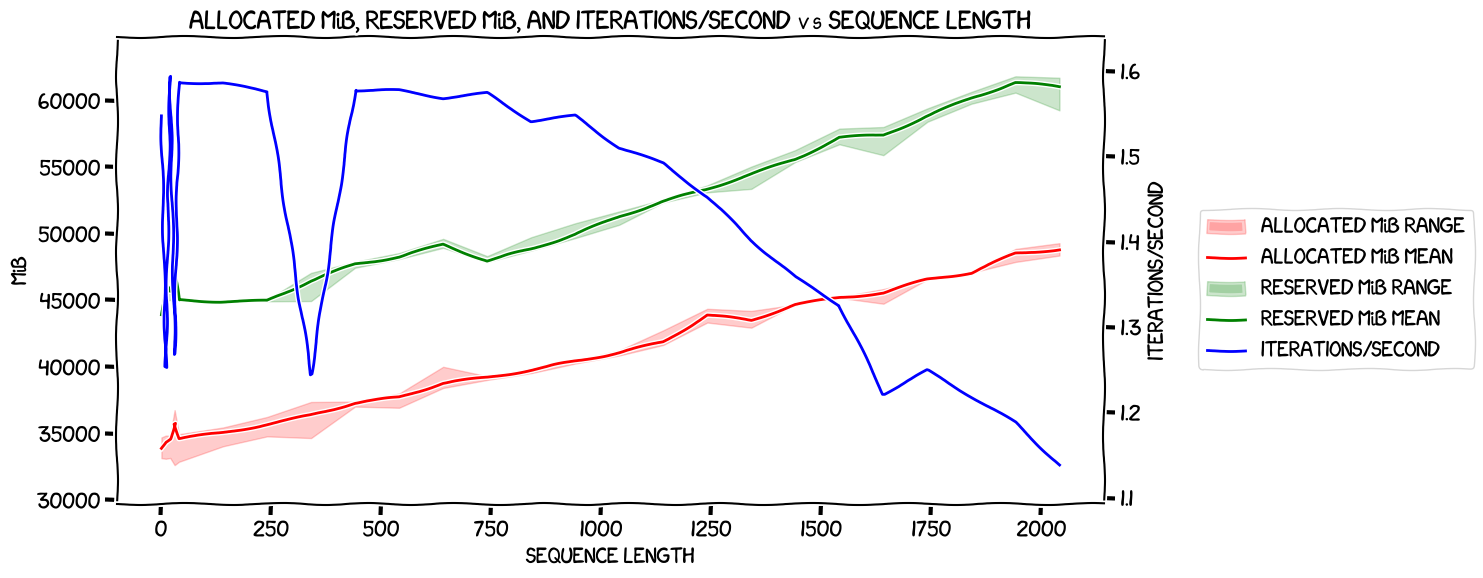

In [13]:
import matplotlib.pyplot as plt

def plot(df):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Allocated MiB
    ax1.fill_between(df['Sequence length'], df['Allocated MiB Min'], df['Allocated MiB Max'], alpha=0.2, color='red', label='ALLOCATED MiB RANGE')
    ax1.plot(df['Sequence length'], df['Allocated MiB Mean'], label='ALLOCATED MiB MEAN', color='red', linewidth=2)

    # Plot Reserved MiB
    ax1.fill_between(df['Sequence length'], df['Reserved MiB Min'], df['Reserved MiB Max'], alpha=0.2, color='green', label='RESERVED MiB RANGE')
    ax1.plot(df['Sequence length'], df['Reserved MiB Mean'], label='RESERVED MiB MEAN', color='green', linewidth=2)

    ax1.set_xlabel('SEQUENCE LENGTH')
    ax1.set_ylabel('MiB')
    ax1.tick_params(axis='y')
    
    # Adjust y-axis limits based on data
    y_min = min(df['Allocated MiB Min'].min(), df['Reserved MiB Min'].min())
    y_max = max(df['Allocated MiB Max'].max(), df['Reserved MiB Max'].max())
    y_range = y_max - y_min
    ax1.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)

    ax2 = ax1.twinx()
    ax2.plot(df['Sequence length'], df['Iterations/second'], label='ITERATIONS/SECOND', color='blue', linewidth=2)
    ax2.set_ylabel('ITERATIONS/SECOND')
    ax2.tick_params(axis='y')
    
    # Adjust y-axis limits for iterations/second
    iter_min, iter_max = df['Iterations/second'].min(), df['Iterations/second'].max()
    iter_range = iter_max - iter_min
    ax2.set_ylim(iter_min - 0.1*iter_range, iter_max + 0.1*iter_range)

    plt.title('ALLOCATED MiB, RESERVED MiB, AND ITERATIONS/SECOND vs SEQUENCE LENGTH')
    fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    
    return fig

# Use the function
fig = plot(normalized_without_df)
plt.show()